source: https://www.physionet.org/about/database/

In [1]:
!wget https://github.com/Yasinkrynk/ecg_signal/archive/refs/heads/main.zip

--2023-06-02 06:06:31--  https://github.com/Yasinkrynk/ecg_signal/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Yasinkrynk/ecg_signal/zip/refs/heads/main [following]
--2023-06-02 06:06:32--  https://codeload.github.com/Yasinkrynk/ecg_signal/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]   3.58M  9.24MB/s    in 0.4s    

2023-06-02 06:06:33 (9.24 MB/s) - ‘main.zip’ saved [3758585]



In [2]:
!unzip main.zip

Archive:  main.zip
2f3d4c8727e5792497de50f0c38e2119f0c4f1de
   creating: ecg_signal-main/
  inflating: ecg_signal-main/r01.edf  
  inflating: ecg_signal-main/r04.edf  


In [3]:
pip install pyEDFlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.4 MB/s eta 0:00:00


In [4]:
from scipy import signal
import pyedflib
import numpy as np
import matplotlib.pyplot as plt

<Figure size 1200x400 with 0 Axes>

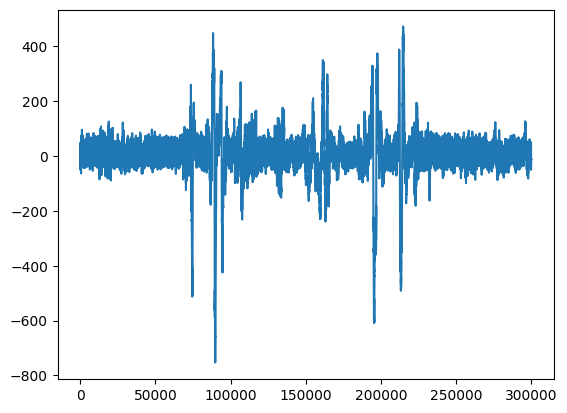

In [5]:
f = pyedflib.EdfReader('/content/drive/MyDrive/DigitalSignalProcessing/r04.edf')
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))

plt.figure(figsize=(12, 4))
fig=plt.figure()
ax=plt.axes()
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
        ax.plot(f.readSignal(i))
        plt.show()

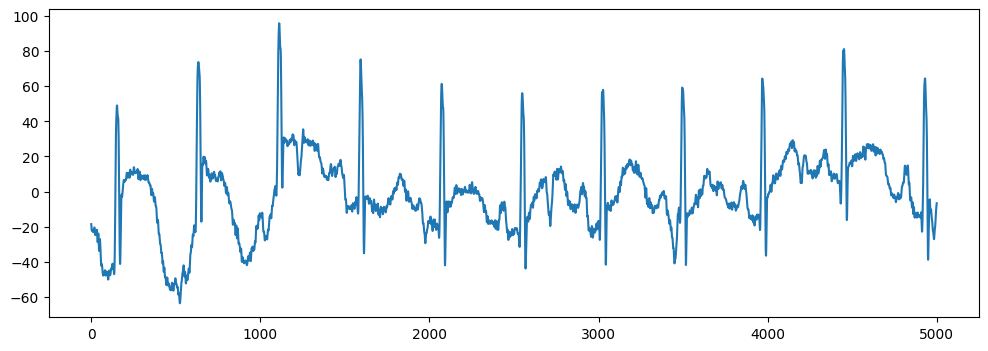

In [6]:
plt.figure(figsize=(12, 4))
data=sigbufs[0, :5000]
plt.plot(data)

In [7]:
N=5
Wc=0.02
b, a = signal.butter(N, Wc, 'lowpass')
filteredLowPass = signal.filtfilt(b, a, data)
b, a = signal.butter(N, Wc, 'highpass')
filteredHighPass = signal.filtfilt(b, a, data)

Text(0.5, 1.0, 'High Filtered')

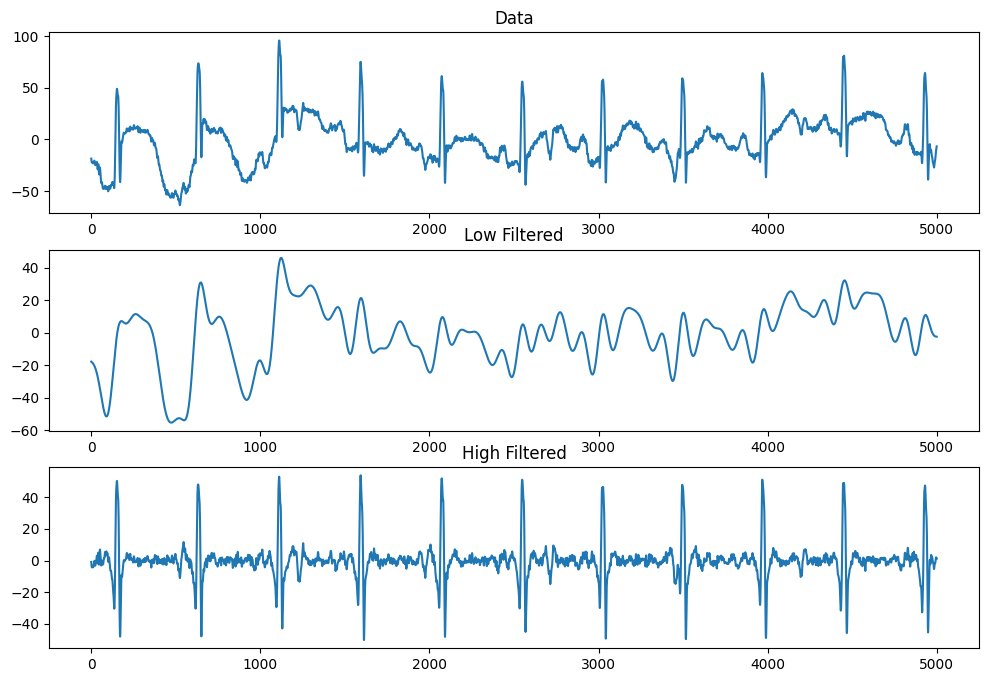

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(data)
plt.title("Data")

plt.subplot(3, 1, 2)
plt.plot(filteredLowPass)
plt.title("Low Filtered")

plt.subplot(3, 1, 3)
plt.plot(filteredHighPass)
plt.title("High Filtered")

In [9]:
def spektrum_cizdir(sinyaller_listesi, frekans_nokta_sayisi=512, sadece_genlik_cizdir=False):
  '''Karşılaştırmalı çizimleri kolaylaştırmak için sinyal(ler) liste olarak alınıyor.
  Listede tek öğe bulunduğu durumda içeriği: [x[n]], ikinci öğe bulunduğu durumda içeriği: [x[n],y[n]] olduğu varsayılıyor 
  '''
  x_n = sinyaller_listesi[0]
  if len(sinyaller_listesi) > 1:
    y_n = sinyaller_listesi[1]
  else:
    y_n = np.array([])
  
  # Fourier dönüşümü bize simetrik bir sonuç vereceği için bütününü oluşturduktan sonra ilk kısmını alalım
  # bu amaçla iki kat boyut kullanıp ortadan böleceğiz
  X_f = np.fft.fft(x_n, frekans_nokta_sayisi * 2)
  X_f = X_f[:frekans_nokta_sayisi]

  # Genlik ve faz bileşenlerinin hesaplanması
  X_abs = np.abs(X_f)
  X_abs[X_abs < np.finfo(float).eps] = np.finfo(float).eps # log operasyonundan önce önlem
  genlik_w_x = 20 * np.log10(X_abs)
  faz_w_x = np.unwrap(np.angle(X_f)) # "unwrap"(katlamayı açma) işlemi eklendi

  if y_n.size > 0:
    Y_f = np.fft.fft(y_n, frekans_nokta_sayisi * 2)
    Y_f = Y_f[:frekans_nokta_sayisi]
    Y_abs = np.abs(Y_f)
    Y_abs[Y_abs < np.finfo(float).eps] = np.finfo(float).eps # log operasyonundan önce önlem
    genlik_w_y = 20 * np.log10(Y_abs);faz_w_y = np.unwrap(np.angle(Y_f))

  # Frekans ekseninde normalize frekans değerleri serisi
  f_normalize = np.arange(0, frekans_nokta_sayisi) / frekans_nokta_sayisi
  
  # Spektrum çizdirme adımları
  plt.figure(figsize=(12,3))
  if sadece_genlik_cizdir:
    plt.title('Genlik spektrumu')
    plt.plot(f_normalize, genlik_w_x, 'b', label='|X($\omega$)|(dB)')
    plt.ylabel('|X($\omega$)|(dB)', color='b')
    plt.xlabel('Normalize frekans [$\pi$ radyan/örnek]')
    plt.grid()
    if y_n.size > 0:
      plt.plot(f_normalize, genlik_w_y, 'r', label='|Y($\omega$)|(dB)')
      plt.legend()
      # görselleri iyileştirmek için eksen sınırlarının kontrolü
      plt.ylim(max(-60, min(np.min(genlik_w_x), np.min(genlik_w_y))), max(np.max(genlik_w_x), np.max(genlik_w_y)))
    else:
      # görselleri iyileştirmek için eksen sınırlarının kontrolü
      plt.ylim(max(-60, np.min(genlik_w_x)), np.max(genlik_w_x))
  else:
    plt.subplot(1,2,1)
    plt.title('Genlik spektrumu')
    plt.plot(f_normalize, genlik_w_x, 'b')
    plt.ylabel('|X($\omega$)|(dB)', color='b')
    plt.xlabel('Normalize frekans [$\pi$ radyan/örnek]')
    plt.grid()
    if y_n.size > 0:
      plt.plot(f_normalize, genlik_w_y, 'r', label='|Y($\omega$)|(dB)')
      plt.legend();
    
    plt.subplot(1,2,2)
    plt.title('Faz spektrumu')
    plt.plot(f_normalize, faz_w_x, 'b', label='faz(X($\omega$))')
    plt.ylabel('faz(X($\omega$)) (radyan)', color='b')
    plt.xlabel('Normalize frekans [$\pi$ radyan/örnek]')
    plt.grid();
    if y_n.size > 0:
      plt.plot(f_normalize, faz_w_y, 'r', label='faz(Y($\omega$))')
      plt.legend();
  plt.show();

In [10]:
def dalga_formu_cizdir(sinyaller_listesi, ornekleme_fr):
  '''Karşılaştırmalı çizimleri kolaylaştırmak için sinyal(ler) liste olarak alınıyor.
  Listede tek öğe bulunduğu durumda içeriği: [x[n]], ikinci öğe bulunduğu durumda içeriği: [x[n],y[n]] olduğu varsayılıyor 
  '''
  x_n = sinyaller_listesi[0]
  if len(sinyaller_listesi) > 1:
    y_n = sinyaller_listesi[1]
  else:
    y_n = np.array([])

  zaman_serisi = np.arange(0, x_n.shape[0]/ornekleme_fr, 1/ ornekleme_fr)
  if zaman_serisi.shape[0] > x_n.shape[0]:
    zaman_serisi = zaman_serisi[:x_n.shape[0]]
  plt.figure(figsize=(12, 4))
  plt.plot(zaman_serisi, x_n, 'b', label='x[n]');
  if y_n.size > 0:
    plt.plot(zaman_serisi, y_n, 'r', label='y[n]');
    plt.legend()
  plt.xlabel('Zaman (saniye)'); plt.ylabel('sinyal genliği');

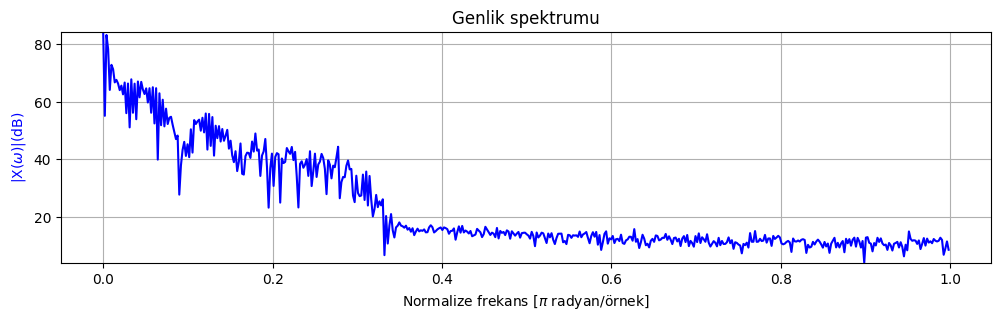

In [11]:
spektrum_cizdir([data], sadece_genlik_cizdir=True)

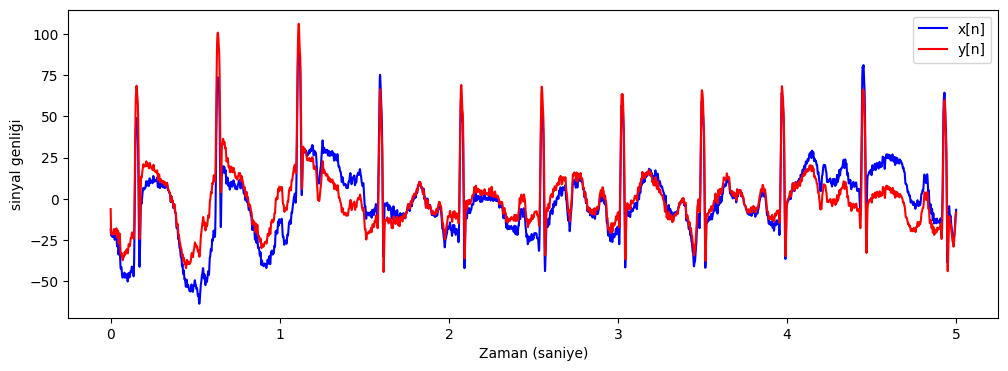

In [12]:
f_sample=1000
f_max=1000*0.5
Wc_alt = 1/f_max
Wc_ust = 150/f_max
n = 1
Wc = [Wc_alt, Wc_ust]
b, a = signal.butter(n, Wc, btype='bandpass')

data_filtering =signal.lfilter(b, a, data)
dalga_formu_cizdir([data, data_filtering], f_sample) 

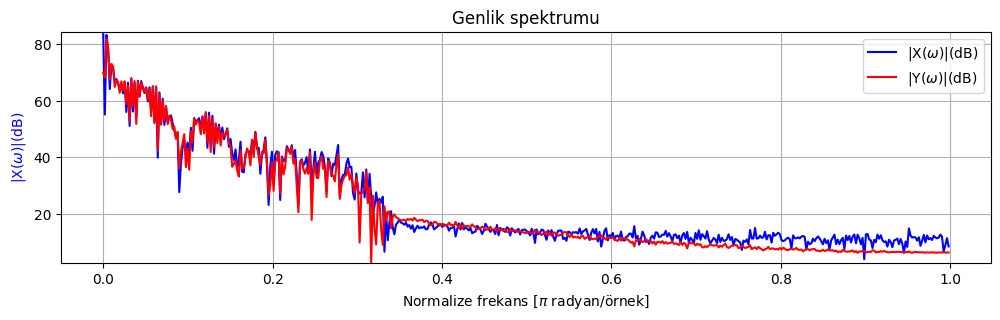

In [13]:
spektrum_cizdir([data, data_filtering], sadece_genlik_cizdir=True)

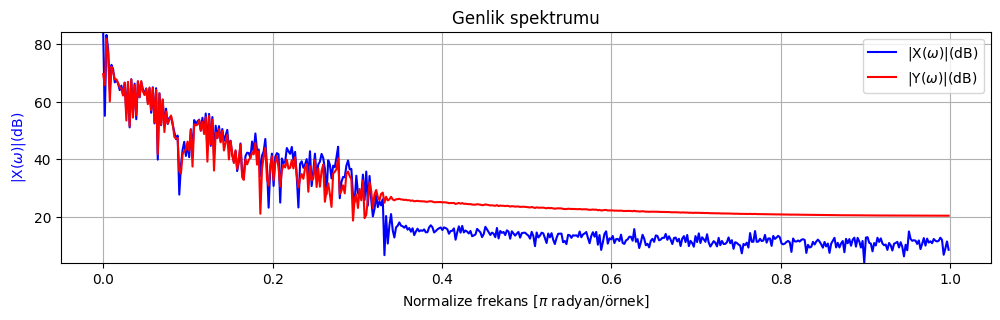

In [14]:
y = signal.filtfilt(b, a, data)
spektrum_cizdir([data, y], sadece_genlik_cizdir=True)

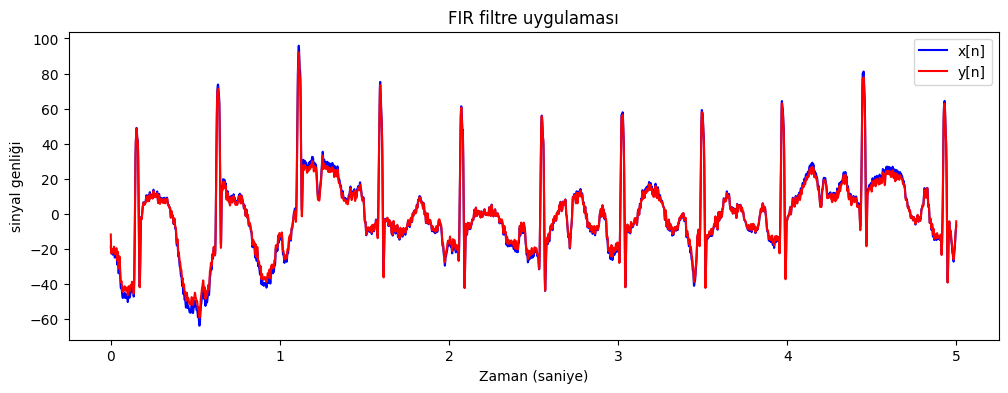

In [16]:
N = 81; 

h_n = signal.firwin(N, Wc,pass_zero='bandpass') 
data_filtering = np.convolve(data, h_n)

data_filtering = data_filtering[N//2:N//2+data.size]
dalga_formu_cizdir([data, data_filtering], f_sample) 
plt.title('FIR filtre uygulaması');

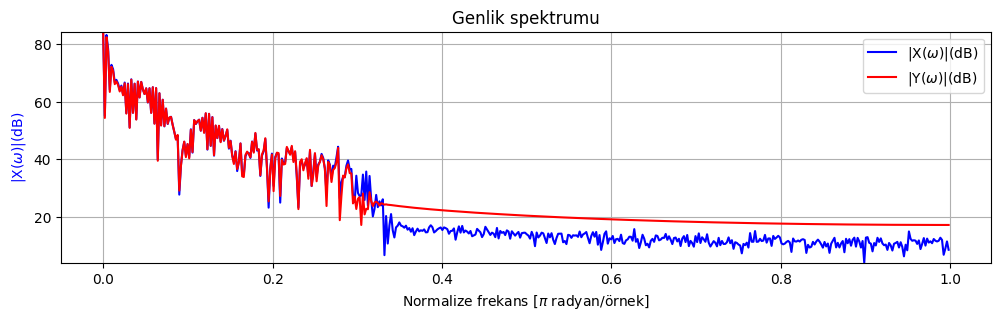

In [17]:
spektrum_cizdir([data, data_filtering], sadece_genlik_cizdir=True)